In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

CORES = -1
SEED = 567

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# !pip install --upgrade pip
# !pip install python-docx
# !pip install antropy

from sklearn.neighbors import NearestNeighbors
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold
#
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
# import antropy as ant
import time
# import docx

# Global utitlity functions are in separate notebook
# import utility_functions as uf
%run ./utility-functions.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
Numpy Seed was set to: 567
Setup Complete


In [58]:
factor=2
style = {
    "figure.figsize": (8, 6),
    "font.family": "serif",  # Ensure that we're using a serif font for LaTeX compatibility
    "text.usetex": True,  # Use LaTeX to format labels and titles    
    "font.size": 12*factor,
    "axes.labelsize": 12*factor,
    "axes.titlesize": 14*factor,
    "xtick.labelsize": 10*factor,
    "ytick.labelsize": 10*factor,
    "lines.linewidth": 2*factor*(3/4),
    "lines.markersize": 8*factor,
    "lines.marker": None,
    "lines.markerfacecolor": 'none',
    "lines.markeredgecolor": 'auto',
    "lines.markeredgewidth": 1.5,
    "legend.fontsize": 10*factor,
    "legend.title_fontsize": 10*factor,
    "axes.grid": True,
    "grid.alpha": 0.53,
    "grid.linewidth": 0.8*factor*(3/4),
    "grid.color": "#D3D3D3",  # A light gray, you can adjust to preference
    "grid.linestyle": "--",
    "axes.facecolor": "white",  # background color of the axes (plotting area)
    "figure.facecolor": "white",  # background color of the figure
    "axes.edgecolor": "#333333",  # color of the borders
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.left": True,
    
    # "font.weight": "bold",       # Bold all text
    # "axes.labelweight": "bold",  # Bold axis labels (redundant if the above line is used, but listed for clarity)
    # "axes.titleweight": "bold",  # Bold title
    # "legend.fontweight": "bold", # Bold legend text
}

plt.rcParams.update(style)
# plt.rc('text', usetex=True)  # Use LaTeX to format labels and titles


utils_boxplot_style=style

In [84]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def format_two_decimal(x, _):
    return f"{x:.2f}"

# ... your plotting code ...




def plot_sys_err_distro(EER_distro_df, discription, save_file_name=None, boxplot_color="springgreen", sys_err=True):
    
    # sns.set(err_distro_rc)
    y_col = "err"
    n_subject = len(EER_distro_df.columns)
    mean_col = EER_distro_df[y_col].mean()
    fig = plt.figure()
    ax = sns.boxplot(x="owner", y=y_col, data=EER_distro_df, color=boxplot_color)#, **utils_boxplot_style)
    
    # Select which box you want to change    
    mybox = ax.patches[3]

    if sys_err:
        
        # Change the appearance of that box
        mybox.set_facecolor('red')
        # mybox.set_edgecolor('black')
        # mybox.set_linewidth(3)
        
    else:
        mybox.set_facecolor('springgreen')
    
    ax.set_ylim((-0.02, 1))
    sns.swarmplot(x="owner", y=y_col, data=EER_distro_df, color=".25", ax=ax)
    
    mean_label = rf'\textbf{{Average EER: {mean_col:.3f}}}'    
    plt.axhline(y=mean_col, color='r', linestyle='-.', marker='', alpha=.8, label=mean_label)

    plt.legend(frameon=True, title="",  loc='upper right')


    fig.tight_layout()
    plt.title(discription)
    
    ax.set_xlabel(r"\textbf{Participants}")
    ax.set_ylabel(r"\textbf{EER}")
    ax.yaxis.set_major_formatter(FuncFormatter(format_two_decimal))

    
    plt.savefig(f'{save_file_name}', bbox_inches='tight')
    print(f"Overall mean: {mean_col:.4f}")
    


In [85]:
def make_sys_error_data(sys_err=True):
    
    
    data = pd.DataFrame(columns = ["owner_id", "err"])
    owner_lst = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    owner_id_lst = []
    cum_err_lst = []
    for owner_id in owner_lst:
        if sys_err:
            if owner_id != 3:
                err_arr = np.random.normal(0.05, 0.01 * random.randint(1, 10), len(owner_lst)-1)
            else:
                err_arr = np.random.normal(0.87, 0.01 * 10 , len(owner_lst)-1)
        else:
            err_arr = np.random.normal(0.05, 0.01 * random.randint(1, 10), len(owner_lst)-1)
        
        neg_data = -1 * err_arr[err_arr<0]
        # print(neg_data)
        # print( data['err'][owner].min())
        err_arr = err_arr[err_arr>0]
        err_arr = np.concatenate([err_arr, neg_data])
        cum_err_lst.append(err_arr)
        owner_id_lst.append(np.repeat(owner_id, len(err_arr)))
        
    cum_err_arr = np.concatenate(cum_err_lst)
    owner_id_arr = np.concatenate(owner_id_lst)
        # data['EER'][owner] = data['err'][owner].mean()
    err_distro_df = pd.DataFrame(data = {"owner": owner_id_arr, "err": cum_err_arr})
    
            
    
    return err_distro_df

In [86]:
np.random.normal(0.91, 0.02, 10)

array([0.88429105, 0.90951964, 0.92850967, 0.94377379, 0.90076999,
       0.9194074 , 0.93631719, 0.89467208, 0.90982697, 0.90234208])

In [87]:
EER_distro_df = make_sys_error_data()

In [88]:
for i in range(10):
    print(EER_distro_df.loc[i])

owner    0.000000
err      0.041602
Name: 0, dtype: float64
owner    0.000000
err      0.049447
Name: 1, dtype: float64
owner    0.000000
err      0.040731
Name: 2, dtype: float64
owner    0.000000
err      0.150619
Name: 3, dtype: float64
owner    0.000000
err      0.053164
Name: 4, dtype: float64
owner    0.000000
err      0.133749
Name: 5, dtype: float64
owner    0.000000
err      0.020009
Name: 6, dtype: float64
owner    0.000000
err      0.104124
Name: 7, dtype: float64
owner    0.000000
err      0.048495
Name: 8, dtype: float64
owner    1.000000
err      0.072726
Name: 9, dtype: float64


In [89]:
EER_distro_df

,owner,err
0,0,0.041602
1,0,0.049447
2,0,0.040731
3,0,0.150619
4,0,0.053164
...,...,...
85,9,0.065970
86,9,0.024867
87,9,0.062860
88,9,0.087476


Overall mean: 0.1463


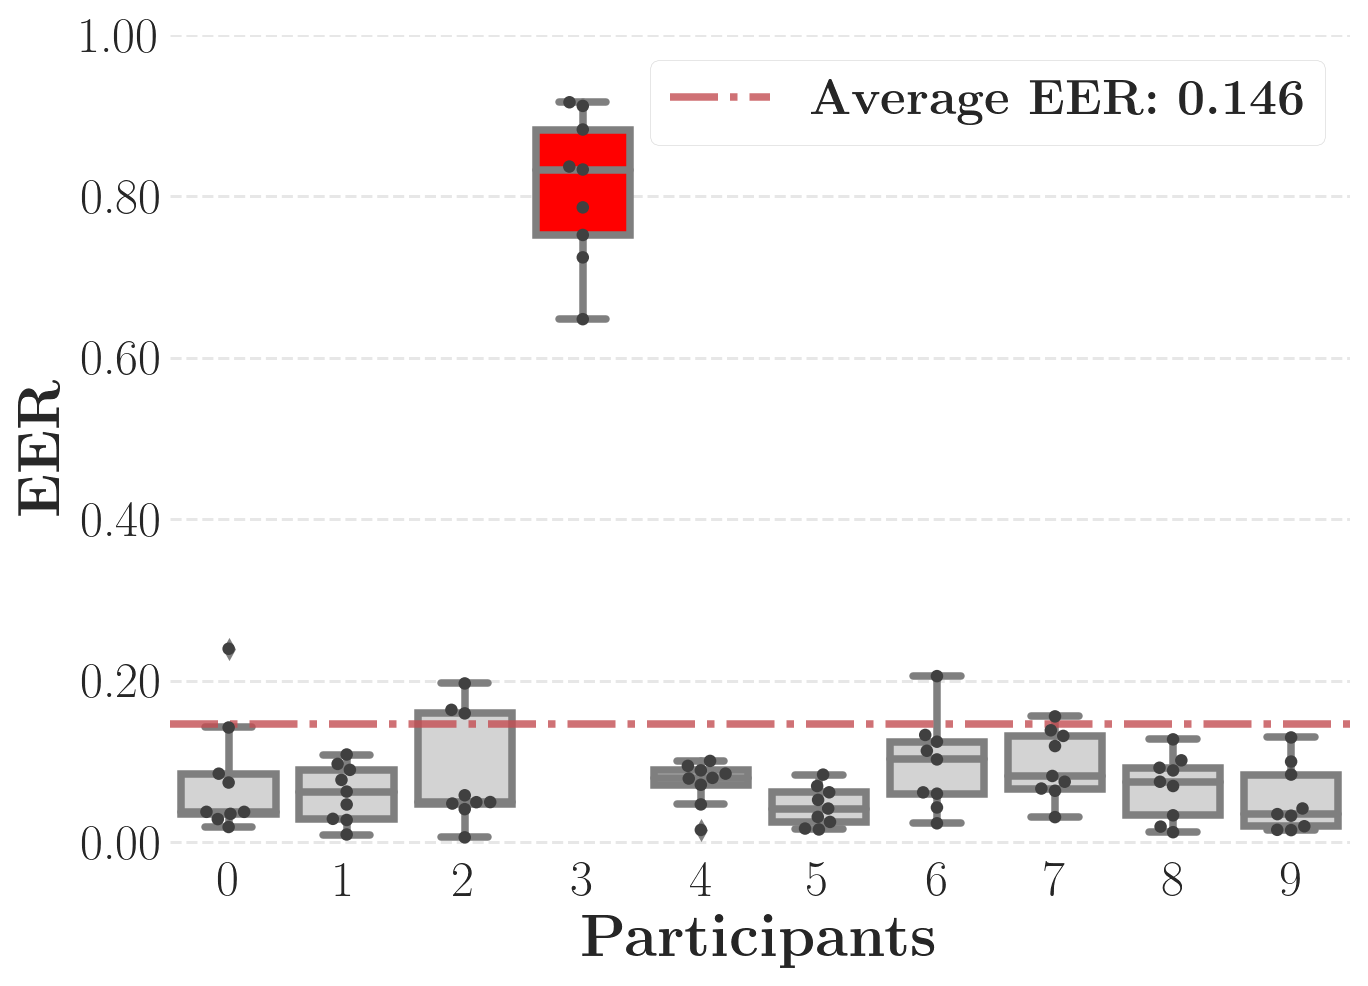

In [90]:
EER_distro_df = make_sys_error_data()
plot_sys_err_distro(EER_distro_df, '', save_file_name=f"Sys_Error.svg", boxplot_color="lightgrey", sys_err=True) 

Overall mean: 0.0739


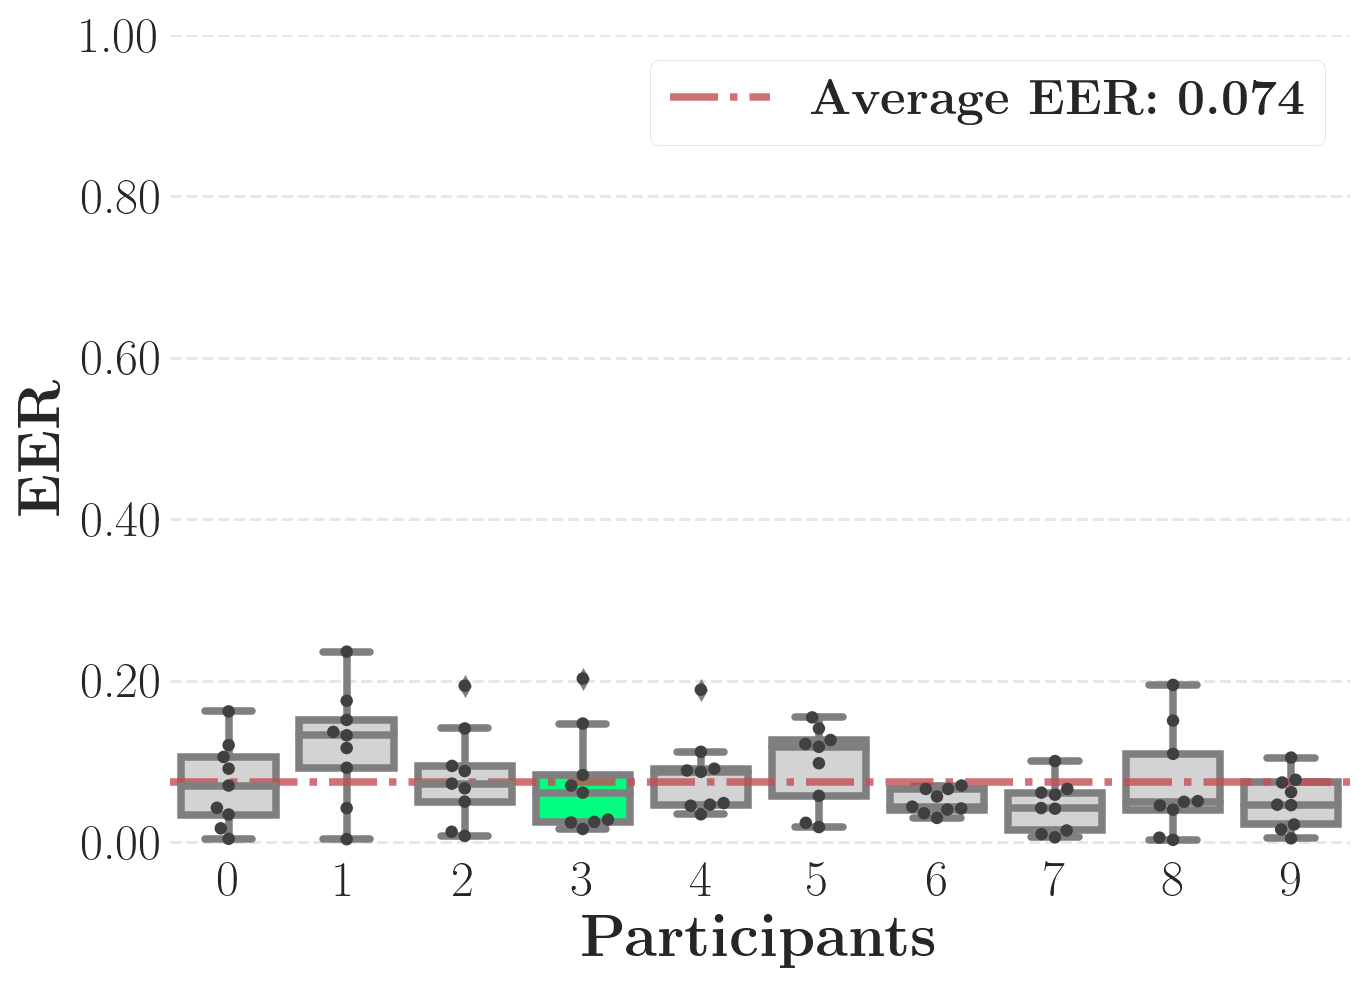

In [91]:
EER_distro_df = make_sys_error_data(sys_err=False)
plot_sys_err_distro(EER_distro_df, '', save_file_name=f"No_Sys_Error.svg", boxplot_color="lightgrey", sys_err=False)

In [13]:
a = np.random.normal(0.05, 0.02, 200)
print(a[a<0])
a=a[a>0]
print(a.shape)
print(a.max())
print(a.min())
print(a.mean())

[]
(200,)
0.10642248768255833
0.003095121442011045
0.05094522670162124


In [14]:
a

array([0.05926069, 0.06036383, 0.06720599, 0.10400791, 0.05985348,
       0.06343091, 0.04728161, 0.09189475, 0.06131388, 0.02574905,
       0.04571764, 0.04343431, 0.06466087, 0.03976778, 0.08265541,
       0.05041746, 0.0504647 , 0.03899262, 0.0651994 , 0.04058931,
       0.0282943 , 0.07957784, 0.05176515, 0.04420166, 0.04526621,
       0.06362517, 0.0216955 , 0.06331214, 0.03812986, 0.05039252,
       0.04616636, 0.06144334, 0.02706842, 0.03661645, 0.01941897,
       0.06318756, 0.0613116 , 0.07104237, 0.03557695, 0.03652756,
       0.02750598, 0.0434545 , 0.08205615, 0.0747165 , 0.03097797,
       0.06106466, 0.02267603, 0.08277486, 0.1016838 , 0.0535585 ,
       0.04971468, 0.02087426, 0.04015824, 0.02042985, 0.04941249,
       0.06930283, 0.06167503, 0.06969262, 0.0621625 , 0.0467638 ,
       0.00499283, 0.00309512, 0.05156764, 0.04359579, 0.05217582,
       0.01364626, 0.06086755, 0.05982287, 0.03451032, 0.06521402,
       0.04816096, 0.04283241, 0.04037632, 0.0595678 , 0.03767